In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('IPO Prediction').getOrCreate()

In [2]:
data = spark.read.csv('ipo.csv', inferSchema=True, header=True)
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- Offer Price: string (nullable = true)
 |-- Opening Price: string (nullable = true)
 |-- 1st Day Close: string (nullable = true)
 |-- 1st Day % Px Chng : string (nullable = true)
 |-- $ Change Opening: string (nullable = true)
 |-- $ Change Close: string (nullable = true)
 |-- Star Ratings: string (nullable = true)
 |-- Performed: string (nullable = true)



In [3]:
data.head(1)

[Row(Date='1/20/17', Issuer='FinTech Acquisition Corp. II', Symbol='FNTEU', Lead/Joint-Lead  Managers='Cantor Fitzgerald & Co.', Offer Price='$10.00', Opening Price='$10.10', 1st Day Close='$10.05', 1st Day % Px Chng ='0.50%', $ Change Opening='$0.10', $ Change Close='$0.05', Star Ratings='1', Performed=None)]

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import col, column, year, to_date, month
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
rem_dollar = udf(lambda x: x if '$' not in str(x) else x.replace('$',''),StringType())
rem_percent = udf(lambda x: x if '%' not in str(x) else x.replace('%', ''), StringType())

In [6]:
data = data.withColumn('Offer_Price', rem_dollar(data['Offer Price']))
data = data.withColumn('Opening_Price', rem_dollar(data['Opening Price']))
data = data.withColumn('1st_Day_Close', rem_dollar(data['1st Day Close']))
data = data.withColumn('Change_Opening', rem_dollar(data['$ Change Opening']))
data = data.withColumn('Change_Close', rem_dollar(data['$ Change Close']))


data = data.withColumn('1_Day_per_chnge', rem_percent(data['1st Day % Px Chng ']))

In [7]:
data = data.select(['Date', 'Issuer', 'Symbol', 'Lead/Joint-Lead  Managers', 'Offer_Price', 'Opening_Price',
                     '1st_Day_Close','1_Day_per_chnge', 'Change_Opening', 'Change_Close', 'Star Ratings',
                    'Performed'])

In [8]:
data = data.withColumn('OfferPrice', data['Offer_Price'].cast(FloatType()))
data = data.withColumn('OpeningPrice', data['Opening_Price'].cast(FloatType()))
data = data.withColumn('1st_DayClose', data['1st_Day_Close'].cast(FloatType()))
data = data.withColumn('1_Day_perChnge', data['1_Day_per_chnge'].cast(FloatType()))
data = data.withColumn('ChangeOpening', data['Change_Opening'].cast(FloatType()))
data = data.withColumn('ChangeClose', data['Change_Close'].cast(FloatType()))


data = data.withColumn('Star_Ratings', data['Star Ratings'].cast(IntegerType()))

data = data.withColumn('date', to_date(data['Date'],'mm/dd/yy'))

In [9]:
data = data.select(['date', 'Issuer', 'Symbol', 'Lead/Joint-Lead  Managers','OfferPrice', 'OpeningPrice',
                     '1st_DayClose', '1_Day_perChnge', 'ChangeOpening', 'ChangeClose', 'Star_Ratings',
                    'Performed'])

In [10]:
data.columns

['date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'OfferPrice',
 'OpeningPrice',
 '1st_DayClose',
 '1_Day_perChnge',
 'ChangeOpening',
 'ChangeClose',
 'Star_Ratings',
 'Performed']

In [11]:
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- OfferPrice: float (nullable = true)
 |-- OpeningPrice: float (nullable = true)
 |-- 1st_DayClose: float (nullable = true)
 |-- 1_Day_perChnge: float (nullable = true)
 |-- ChangeOpening: float (nullable = true)
 |-- ChangeClose: float (nullable = true)
 |-- Star_Ratings: integer (nullable = true)
 |-- Performed: string (nullable = true)



In [12]:
data = data.withColumn('Year', year(data['date']))

In [13]:
data.show(140)

+----------+--------------------+------+-------------------------+----------+------------+------------+--------------+-------------+-----------+------------+---------+----+
|      date|              Issuer|Symbol|Lead/Joint-Lead  Managers|OfferPrice|OpeningPrice|1st_DayClose|1_Day_perChnge|ChangeOpening|ChangeClose|Star_Ratings|Performed|Year|
+----------+--------------------+------+-------------------------+----------+------------+------------+--------------+-------------+-----------+------------+---------+----+
|2017-01-20|FinTech Acquisiti...| FNTEU|     Cantor Fitzgerald...|      10.0|        10.1|       10.05|           0.5|          0.1|       0.05|           1|     null|2017|
|2017-01-20|        Keane Group |  FRAC|     Citigroup/ Morgan...|      19.0|       22.18|       21.65|         13.95|         3.18|       2.65|           3|     null|2017|
|2017-01-26|         AnaptysBio |  ANAB|     Credit Suisse/ St...|      15.0|        16.0|        17.0|         13.33|          1.0|   

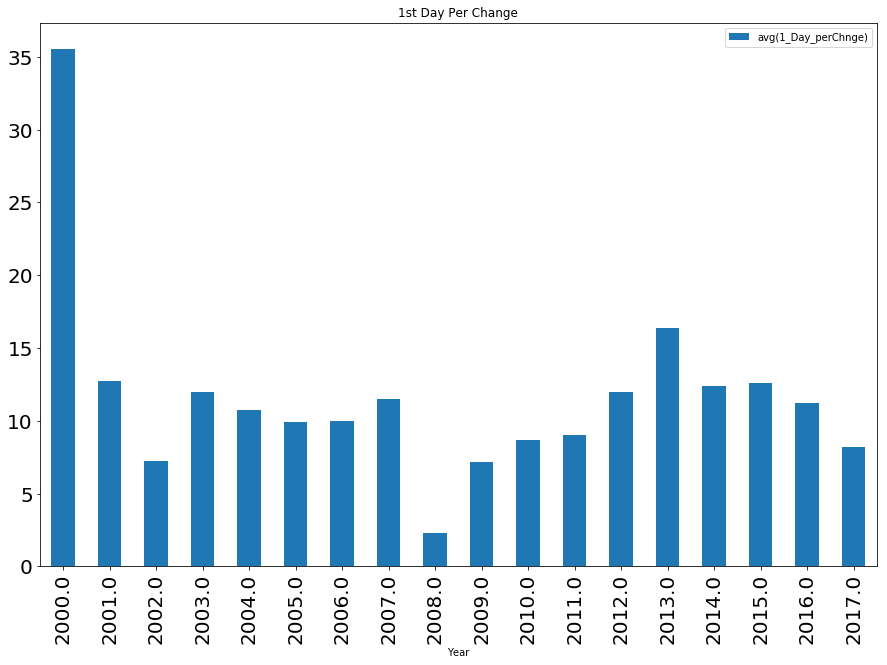

In [14]:
pdData = data.groupBy(data['Year']).mean('1_Day_perChnge').orderBy('Year').toPandas()
pdData.dropna(inplace=True)
pdData.set_index(keys='Year', inplace=True)
pdData.plot(kind = 'bar', figsize = (15,10), title = '1st Day Per Change', fontsize=20)

In [15]:
data.select('1_Day_perChnge').describe().show()

+-------+------------------+
|summary|    1_Day_perChnge|
+-------+------------------+
|  count|              2885|
|   mean|13.006758228490256|
| stddev|27.435829973069115|
|    min|            -35.22|
|    max|            353.85|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4da6681dd8>]], dtype=object)

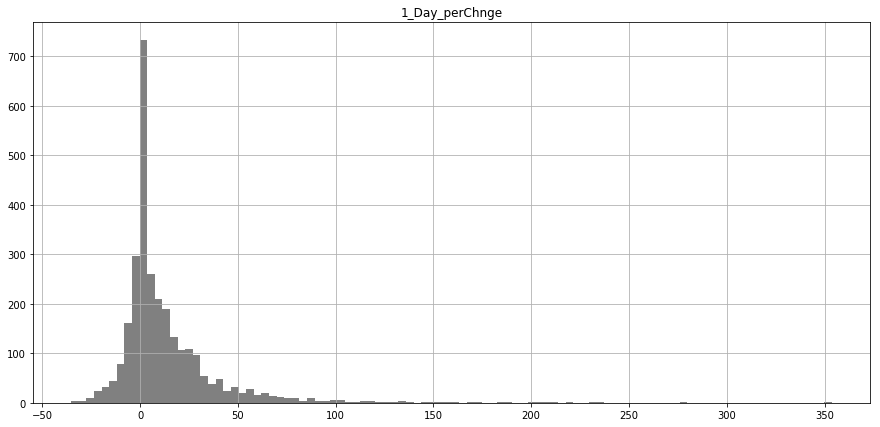

In [16]:
data.select('1_Day_perChnge').toPandas().hist(figsize=(15,7), bins=100, color='grey')

In [17]:
data = data.withColumn('chngeOpentoClose', data['ChangeClose']-data['ChangeOpening'])
data = data.withColumn('percentChnge', data['chngeOpentoClose']/data['OpeningPrice']*100)
data.show()

+----------+--------------------+------+-------------------------+----------+------------+------------+--------------+-------------+-----------+------------+---------+----+----------------+-------------------+
|      date|              Issuer|Symbol|Lead/Joint-Lead  Managers|OfferPrice|OpeningPrice|1st_DayClose|1_Day_perChnge|ChangeOpening|ChangeClose|Star_Ratings|Performed|Year|chngeOpentoClose|       percentChnge|
+----------+--------------------+------+-------------------------+----------+------------+------------+--------------+-------------+-----------+------------+---------+----+----------------+-------------------+
|2017-01-20|FinTech Acquisiti...| FNTEU|     Cantor Fitzgerald...|      10.0|        10.1|       10.05|           0.5|          0.1|       0.05|           1|     null|2017|           -0.05|-0.4950494936296446|
|2017-01-20|        Keane Group |  FRAC|     Citigroup/ Morgan...|      19.0|       22.18|       21.65|         13.95|         3.18|       2.65|           3|   

In [18]:
data.select('percentChnge').describe().show()

+-------+------------------+
|summary|      percentChnge|
+-------+------------------+
|  count|              2885|
|   mean|1.3226170777349027|
| stddev|10.858205546142765|
|    min| -98.5221650191643|
|    max| 159.4174735167888|
+-------+------------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4da645d8d0>]], dtype=object)

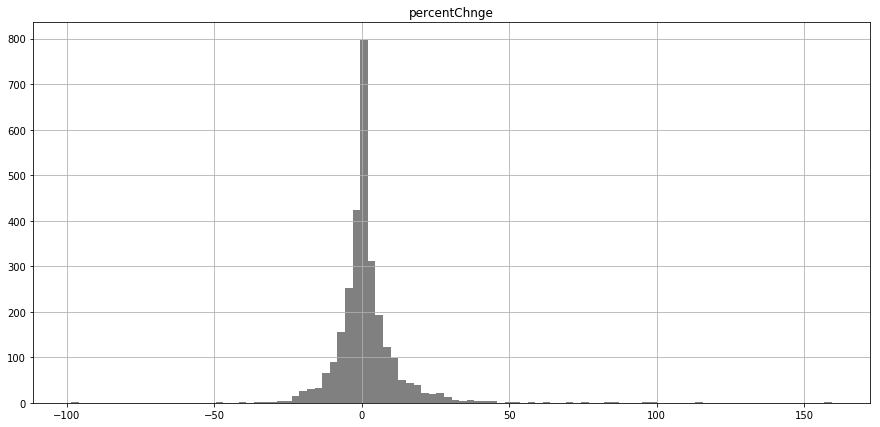

In [19]:
data.select('percentChnge').toPandas().hist(figsize=(15,7), bins=100, color='grey')

**Feature Engineering**

In [20]:
import pandas as pd
sp = pd.read_csv('spy.csv', encoding = 'latin')
sp.sort_values('Date', inplace=True)
sp.reset_index(drop=True, inplace = True)

In [21]:
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,100.323436
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,111579900,100.589001
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,116074400,100.659822
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,131091100,101.084736
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,126402800,101.421122


In [49]:
# Method to find weekly change
def weeklyChange(ipos):
    try:
        dayAgoIndex = sp[sp['Date'] == str(ipos)].index[0] - 1     #yesterday's data
        weekAgoIndex = sp[sp['Date'] == str(ipos)].index[0] - 8    #week's before data
        change = (sp.iloc[dayAgoIndex]['Close'] - sp.iloc[weekAgoIndex]['Close']) / sp.iloc[weekAgoIndex]['Close']
        return change * 100
    except:
        print("error : ", ipos)

In [50]:
week_change = udf(weeklyChange, FloatType())
data = data.withColumn("SP Week Change", week_change(data['date']))

In [51]:
def add_lead_mgr(x):
    try:
        return x.split('/')[0]
    except:
        print('error', x)
        
lead_mgr_udf = udf(add_lead_mgr, StringType())

data = data.withColumn("Lead Mgr", lead_mgr_udf(data['Lead/Joint-Lead  Managers']))

In [52]:
data.columns

['date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'OfferPrice',
 'OpeningPrice',
 '1st_DayClose',
 '1_Day_perChnge',
 'ChangeOpening',
 'ChangeClose',
 'Star_Ratings',
 'Performed',
 'Year',
 'chngeOpentoClose',
 'percentChnge',
 'SP Week Change',
 'Lead Mgr',
 'Total Underwriters',
 'Day',
 'Month',
 'Gap Open Pct',
 'labels']

In [53]:
data.select('Lead Mgr').show(truncate=False)

+--------------------------------------------------+
|Lead Mgr                                          |
+--------------------------------------------------+
|Cantor Fitzgerald & Co.                           |
|Citigroup                                         |
|Credit Suisse                                     |
|Credit Suisse                                     |
|Citigroup                                         |
|Barclays                                          |
|J.P. Morgan                                       |
|Goldman Sachs                                     |
|Deutsche Bank Securities                          |
|Credit Suisse                                     |
|Raymond James                                     |
|Credit Suisse                                     |
|FBR                                               |
|Deutsche Bank Securities                          |
|Joseph Gunnar                                     |
|J.P. Morgan                                  

In [54]:
dict={
    'Hambrecht':'WR Hambrecht+Co.',
    'Edwards':'AG Edwards',
    'Edwrads':'AG Edwards',
    'Barclay':'Barclays',
    'Aegis':'Aegis Capital',
    'Deutsche':'Deutsche Bank',
    'Suisse':'CSFB',
    'CS.?F':'CSFB',
    '^Early':'EarlyBirdCapital',
    'Keefe':'Keefe, Bruyette & Woods',
    'Stan':'Morgan Stanley',
    'P. Morg':'JP Morgan',
    'PM':'JP Morgan',
    'J\.P\.':'JP Morgan',
    'Banc of':'Banc of America',
    'Lych':'BofA Merrill Lynch',
    'Merrill$':'Merrill Lynch',
    'Lymch':'Merrill Lynch',
    'A Merril Lynch':'BofA Merrill Lynch',
    'Merril ':'Merrill Lynch',
    'BofA$':'BofA Merrill Lynch',
    'SANDLER':'Sandler O\'neil + Partners',
    'Sandler':'Sandler O\'Neil + Partners',
    'Renshaw':'Rodman & Renshaw',
    'Baird':'RW Baird',
    'Cantor':'Cantor Fitzgerald',
    'Goldman':'Goldman Sachs',
    'Bear':'Bear Stearns',
    'BoA':'BofA Merrill Lynch',
    'Broadband':'Broadband Capital',
    'Davidson':'DA Davidson',
    'Feltl':'Feltl & Co.',
    'China':'China International',
    'Cit':'Citigroup',
    'Ferris':'Ferris Baker Watts',
    'Friedman|Freidman|FBR':'Friedman Billings Ramsey',
    '^I-':'I-Bankers',
    'Gunn':'Gunn Allen',
    'Jeffer':'Jefferies',
    'Oppen':'Oppenheimer',
    'JMP':'JMP Securities',
    'Rice':'Johnson Rice',
    'Ladenburg':'Ladenburg Thalmann',
    'Piper':'Piper Jaffray',
    'Pali':'Pali Capital',
    'Paulson':'Paulson Investment Co.',
    'Roth':'Roth Capital',
    'Stifel':'Stifel Nicolaus',
    'SunTrust':'SunTrust Robinson',
    'Wachovia':'Wachovia',
    'Wedbush':'Wedbush Morgan',
    'Blair':'William Blair',
    'Wunderlich':'Wunderlich',
    'Max':'Maxim Group',
    'CIBC':'CIBC',
    'CRT':'CRT Capital',
    'HCF':'HCFP Brenner',
    'Cohen':'Cohen & Co.',
    'Cowen':'Cowen & Co.',
    'Leerink':'Leerink Partners',
    'Lynch\xca':'Merrill Lynch',
    'Sandler O’Neill + Partners, L.P.':"Sandler O'Neil + Partners",
    ' J.P. Morgan':'J.P. Morgan'
}

In [55]:
def manager(row):
    if row in dict:
        print(dict[row])
        return dict[row]
    else:        
        return row
    
manager_udf = udf(manager, StringType())
data = data.withColumn("Lead Mgr", manager_udf(data['Lead Mgr']))
data.select(['Lead Mgr']).show()

+--------------------+
|            Lead Mgr|
+--------------------+
|Cantor Fitzgerald...|
|           Citigroup|
|       Credit Suisse|
|       Credit Suisse|
|           Citigroup|
|            Barclays|
|         J.P. Morgan|
|       Goldman Sachs|
|Deutsche Bank Sec...|
|       Credit Suisse|
|       Raymond James|
|       Credit Suisse|
|                 FBR|
|Deutsche Bank Sec...|
|       Joseph Gunnar|
|         J.P. Morgan|
|      Morgan Stanley|
|  BofA Merrill Lynch|
|Rodman & Renshaw ...|
|         J.P. Morgan|
+--------------------+
only showing top 20 rows



In [56]:
data.select('Lead Mgr').distinct().orderBy('Lead Mgr').select('Lead Mgr').show()

+--------------------+
|            Lead Mgr|
+--------------------+
|                null|
|      Morgan Stanley|
| Deutsche Bank Se...|
|       Raymond James|
|        A.G. Edwards|
| A.G. Edwards & Sons|
| A.G. Edwrads & Sons|
|          AG Edwards|
|   AG Edwards & Sons|
|          AG Edwrads|
|      Adams Harkness|
|              Advest|
|       Aegis Capital|
|      Aegis Capital |
|  Aegis Capital Corp|
| Aegis Capital Corp.|
|Anderson & Strudrick|
|Axiom Capital Man...|
|BB&T Capital Markets|
|                BBVA|
+--------------------+
only showing top 20 rows



In [57]:
def under_writers(x):
    try:
        return len(x.split('/'))
    except:
        print('error', x)
        
under_writers_udf = udf(under_writers, StringType())
data = data.withColumn("Total Underwriters", under_writers_udf(data['Lead/Joint-Lead  Managers']).cast(IntegerType()))
data.select('Total Underwriters').show()

+------------------+
|Total Underwriters|
+------------------+
|                 1|
|                 4|
|                 2|
|                 3|
|                 3|
|                 4|
|                 2|
|                 3|
|                 8|
|                 9|
|                 3|
|                 3|
|                 2|
|                 5|
|                 1|
|                 2|
|                 4|
|                 3|
|                 1|
|                 2|
+------------------+
only showing top 20 rows



In [58]:
data.columns

['date',
 'Issuer',
 'Symbol',
 'Lead/Joint-Lead  Managers',
 'OfferPrice',
 'OpeningPrice',
 '1st_DayClose',
 '1_Day_perChnge',
 'ChangeOpening',
 'ChangeClose',
 'Star_Ratings',
 'Performed',
 'Year',
 'chngeOpentoClose',
 'percentChnge',
 'SP Week Change',
 'Lead Mgr',
 'Total Underwriters',
 'Day',
 'Month',
 'Gap Open Pct',
 'labels']

In [59]:
from pyspark.sql.functions import date_format
data = data.withColumn("Day",date_format('date', 'E'))

In [60]:
monthdict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun',7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
def month_name(inp):
    if inp in monthdict:
        print(monthdict[inp])
        return monthdict[inp]
    else:        
        return inp  
    
month_udf = udf(month_name, StringType())

In [61]:
data = data.withColumn("Month", month_udf(month(data['date'])))
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- Issuer: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Lead/Joint-Lead  Managers: string (nullable = true)
 |-- OfferPrice: float (nullable = true)
 |-- OpeningPrice: float (nullable = true)
 |-- 1st_DayClose: float (nullable = true)
 |-- 1_Day_perChnge: float (nullable = true)
 |-- ChangeOpening: float (nullable = true)
 |-- ChangeClose: float (nullable = true)
 |-- Star_Ratings: integer (nullable = true)
 |-- Performed: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- chngeOpentoClose: float (nullable = true)
 |-- percentChnge: double (nullable = true)
 |-- SP Week Change: float (nullable = true)
 |-- Lead Mgr: string (nullable = true)
 |-- Total Underwriters: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Gap Open Pct: double (nullable = true)
 |-- labels: integer (nullable = true)



In [62]:
data = data.withColumn("Gap Open Pct",\
                       (data['ChangeOpening']/data['OpeningPrice'])*100)